In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib
import matplotlib.pyplot as plt

In [6]:
print(tf.__version__)

2.6.0


In [7]:
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(10)

### reference: [Load and process images](https://www.tensorflow.org/tutorials/load_data/images)

## 1. Download the flowers dataset (a dataset of several thousands photos of flowers)

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

228827136/228813984 [==============================] - 13s 0us/step


In [8]:
data_dir = "/mnt/Storage/home/yuzhaowei/.keras/datasets/flower_photos"
data_dir = pathlib.Path(data_dir)

In [9]:
list(data_dir.glob('*/*.jpg'))[0]

PosixPath('/mnt/Storage/home/yuzhaowei/.keras/datasets/flower_photos/sunflowers/5027895361_ace3b731e5_n.jpg')

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [11]:
roses = list(data_dir.glob('roses/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))

## 2. Load single image with PIL (python image library)

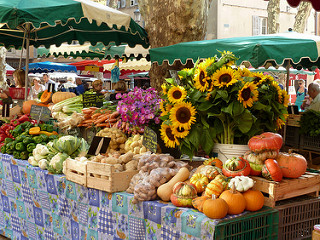

In [12]:
# open images with PIL
PIL.Image.open(str(sunflowers[0]))

In [13]:
# convert image to matrix
rose = PIL.Image.open(str(roses[0]))
np.array(rose).shape

(313, 500, 3)

## 3. Load single image with matplotlib

(240, 320, 3)


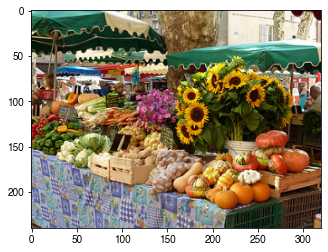

In [14]:
from matplotlib.image import imread

# load image to matrix with matplotlib
image = imread(sunflowers[0])
print(image.shape)

plt.imshow(image) # show the image from matrix

## 4. Resize image with TensorFlow

>When training vision models, it is common to resize images to a lower dimension ((224 x 224), (299 x 299), etc.) to allow mini-batch learning and also to keep up the compute limitations. We generally make use of image resizing methods like <b>bilinear interpolation</b> for this step and the resized images do not lose much of their perceptual character to the human eyes. In [Learning to Resize Images for Computer Vision Tasks](https://arxiv.org/abs/2103.09950v1), Talebi et al. show that if we try to optimize the perceptual quality of the images for the vision models rather than the human eyes, their performance can further be improved.

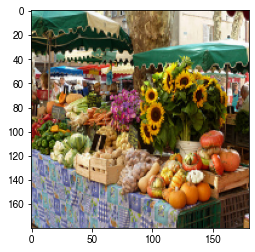

In [15]:
image_resize = tf.image.resize(image, (180, 180), method = "bilinear")
plt.imshow(image_resize.numpy().astype("uint8"))

## 5. Load multiple images from directory with tf.keras.preprocessing

In [16]:
# define some parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2, # use 80% of images for training and 20% for validation
  subset = "training",    # one of "training" or "validation", only used if validation_split is set.
  seed = 123,
  image_size = (img_height, img_width), # 
  batch_size = batch_size) # size of the batches of data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2, # use 80% of images for training and 20% for validation
  subset = "validation",    # one of "training" or "validation", only used if validation_split is set.
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size) # size of the batches of data

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
# find the class names in the class_names attribute on these datasets.

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


tf.Tensor([2 1 4 3 1 2 1 2 4 1 4 4 3 4 1 2 0 4 1 1 1 4 3 2 3 1 4 2 2 3 4 3], shape=(32,), dtype=int32)


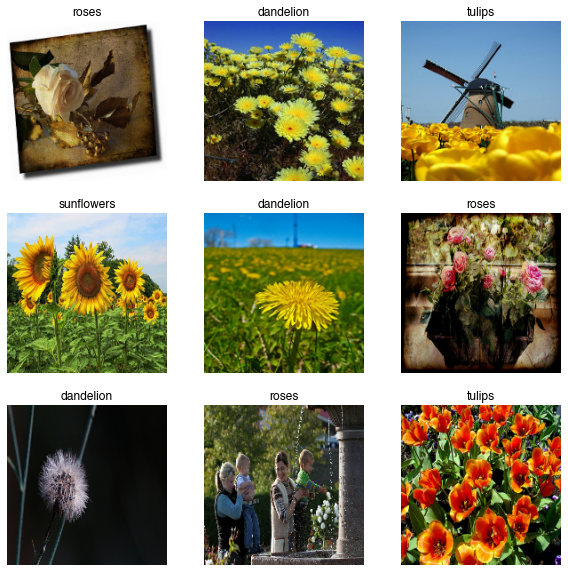

In [18]:
# visualize the data

plt.figure(figsize=(10, 10))
count = 0
for images, labels in train_ds.take(1): # get one training batch
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
# load all traning batches with batch size = 32
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # a tensor of the shape (32, 180, 180, 3) 
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## 6. Implement a deep learning model for image classification

### 6.1 Configure the dataset for performance

Let's make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(type(train_ds))
print(type(val_ds))

-1
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


### 6.2 Train a model

In [21]:
num_classes = 5

# groups a linear stack of layers
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255), # rescale an input in the [0, 255] range to be in the [0, 1] range, in general you should make your input value small 
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'), # 2D convolution layer
  tf.keras.layers.MaxPooling2D(), # Max pooling for 2D spatial data
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(), # Flatten input 
  tf.keras.layers.Dense(128, activation='relu'), # Densely-connected NN layer.
  tf.keras.layers.Dense(num_classes)
])

# optimization algorithms
model.compile(optimizer = "adam",
            loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), # Computes the crossentropy loss between the labels and predictions.
              metrics = ["accuracy"]
             )



model.fit(train_ds, 
        validation_data=val_ds,
          epochs=3
         )


Epoch 1/3
92/92 [==============================] - 138s 1s/step - loss: 1.2905 - accuracy: 0.4384 - val_loss: 1.0949 - val_accuracy: 0.5422
Epoch 2/3
92/92 [==============================] - 134s 1s/step - loss: 0.9649 - accuracy: 0.6168 - val_loss: 0.9868 - val_accuracy: 0.5913
Epoch 3/3
92/92 [==============================] - 134s 1s/step - loss: 0.7882 - accuracy: 0.6969 - val_loss: 0.9676 - val_accuracy: 0.6008
